[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gllodra12/qosf_2023_10/blob/master/Task_1.ipynb)

# Grover's algorithm






In [95]:
# Run this cell only in Google Colab
# Uncomment
#!pip install pennylane matplotlib

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

Proposed by Lov Grover in 1996, this [quantum search algorithm](https://arxiv.org/abs/quant-ph/9605043) offers an ingenious solution to one of computing's fundamental problems: searching an unsorted database. 

In his original paper, Grover aimed to locate a particular phone number within a catalog containing N phone numbers arranged randomly. Classical algorithms require at least N/2 numbers to find the desired item. Grover's Algorithm, on the other hand, employs a radically distinct approach. Harnessing the principles of quantum superposition and interference, it can search in approximately √N steps, showcasing a quadratic speedup compared to the most efficient classical algorithms available.

The magic of Grover's Algorithm lies in its ability to manipulate quantum states in a way that enhances the probability of finding the correct solution. Through cleverly designed quantum operations, it amplifies the amplitude of the correct solution while diminishing the amplitudes of incorrect solutions. This process, known as amplitude amplification, enables Grover's Algorithm to achieve remarkable speedup compared to classical counterparts.

The algorithm follows these steps:
1. Prepare a superposition state of all possible solutions.
2. Apply the oracle.
3. Apply the Grover operator.
4. Repeat steps 2 and 3 approximately $\lfloor\frac{\pi}{4}\sqrt{N}\rfloor$ times.






## Task 1: Find prime numbers

In the README, we have already explain the task. But basically, the idea is to **find** two numbers in a list of N numbers that add up to an initial number x. Given that this task involves searching for elements in a list, Grover's Algorithm appears to be the ideal approach. In the following, our focus will be on the most challenging aspect of the problem: defining an oracle that can validate the solution.

We have an initial number and list of prime numbers

```python
num=15
prime_list = [2, 3, 5, 7, 11, 13]
```

In this case, we want to see if the algorithm is able to pick the numbers 2 and 13.

```python
exp_solution = [1, 0, 0, 0, 0, 1]
```

In [3]:
num = 8
prime_list = [2, 3, 5]

variables_wires = [0, 1, 2] # initial qubits
aux_oracle_wires = [3, 4, 5, 6] # auxiliar qubits

To tackle this problem, we employ a total of n+m qubits. The initial n qubits represent the length of the prime list, while the additional m qubits serve as auxiliary storage for the sum of different numbers in the prime list. _In this case, we need $m=4$ auxiliar qubits are required to store the number 8 in binary (1000), as 8 represents the total sum of the prime list._

As you remember, the first step of the algorithm is to prepare a superposition state with all the solutions:

initial_state = $\frac{1}{\sqrt{8}}(|000\rangle + |001\rangle + ... + |111\rangle)$

The second step is to apply the oracle. The oracle checks each qubit and adds the corresponding value from the prime list if the respective qubit is set to one. Once all qubits have been inspected, the correct solution is marked by a negative sign.

To illustrate the oracle's functionality, consider a specific state, such as $|011\rangle$.

- Qubit 0 is 0, so the value 2 is not added.
- Qubit 1 is 1, leading to the addition of the value 3.
- Qubit 2 is 1, leading to the addition of the value 5.

In total, the auxiliary qubits accumulate a sum of 8. The oracle verifies whether this total aligns with the correct solution and, if so, flips the sign, altering the state as follows:

state = $\frac{1}{\sqrt{8}}(|000\rangle + |001\rangle + ... - |011\rangle +... + |111\rangle)$.

The third step, amplifies the right solution.

amplified state = $\sqrt{0.03}|000\rangle + \sqrt{0.03}|001\rangle + ... + \sqrt{0.79}|011\rangle + ... + \sqrt{0.03}|111\rangle $.

_*The amplitude coefficients correspond to the next bar plot_

In [4]:
def oracle_primes(num, prime_list, variables_wires, aux_oracle_wires):
  # Auxiliar function: Sum prime numbers
  def add_k_fourier(k, wires):
    for j in range(len(wires)):
      qml.RZ(k * np.pi / (2**j), wires=wires[j])

  # Choose the values in the prime_list that you want to add together.
  def prime_counter():
    qml.QFT(wires = aux_oracle_wires)
    for wire in variables_wires:
      qml.ctrl(add_k_fourier, control = wire)(prime_list[wire], wires=aux_oracle_wires)
    qml.adjoint(qml.QFT)(wires = aux_oracle_wires)

  prime_counter()
  # Highlight the right solution 
  qml.FlipSign(num, wires = aux_oracle_wires)
  qml.adjoint(prime_counter)()


In [5]:
dev_probs = qml.device("default.qubit", wires = variables_wires + aux_oracle_wires)

@qml.qnode(dev_probs)
def find_the_primes_numbers(num: int, prime_list: list[int], variables_wires, aux_oracle_wires, iterations=1):
    """
    num: integer value that is the positive number to decompose
    prime_list: integer list that has two prime numbers to add to obtain num

    Returns: num_1 and num_2 from prime_list that add to num
    """
    for wire in variables_wires:
        qml.Hadamard(wires=wire)
    for _ in range(iterations):
        oracle_primes(num, prime_list, variables_wires, aux_oracle_wires)
        qml.GroverOperator(wires = variables_wires)
    return qml.probs(wires=variables_wires)
    

<BarContainer object of 8 artists>

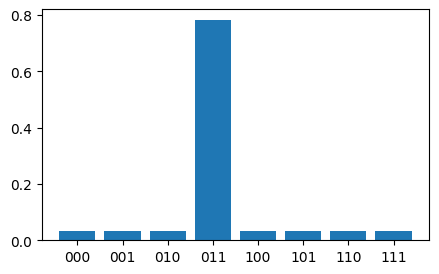

In [6]:
values = find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations=1)

def integers_to_binary(integers, length=3):
    binaries = list()
    for i in integers:
        binaries.append(format(i, f"0{length}b"))
    return binaries

plt.figure(figsize=(5, 3))
plt.bar(integers_to_binary(range(len(values))), values)

Finally to increase the probability, we can repeat the 2nd and 3rd step with the parameter `iterations`.

<BarContainer object of 8 artists>

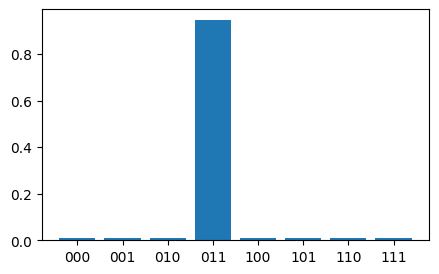

In [7]:
values = find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)

plt.figure(figsize=(5, 3))
plt.bar(integers_to_binary(range(len(values))), values)

So, the following quantum circuit produce as the more probable output the solution "011" which corresponds to the values 2 and 3 of the prime list. In the next section, we will test the previous code with a different `num` and `prime_list`.

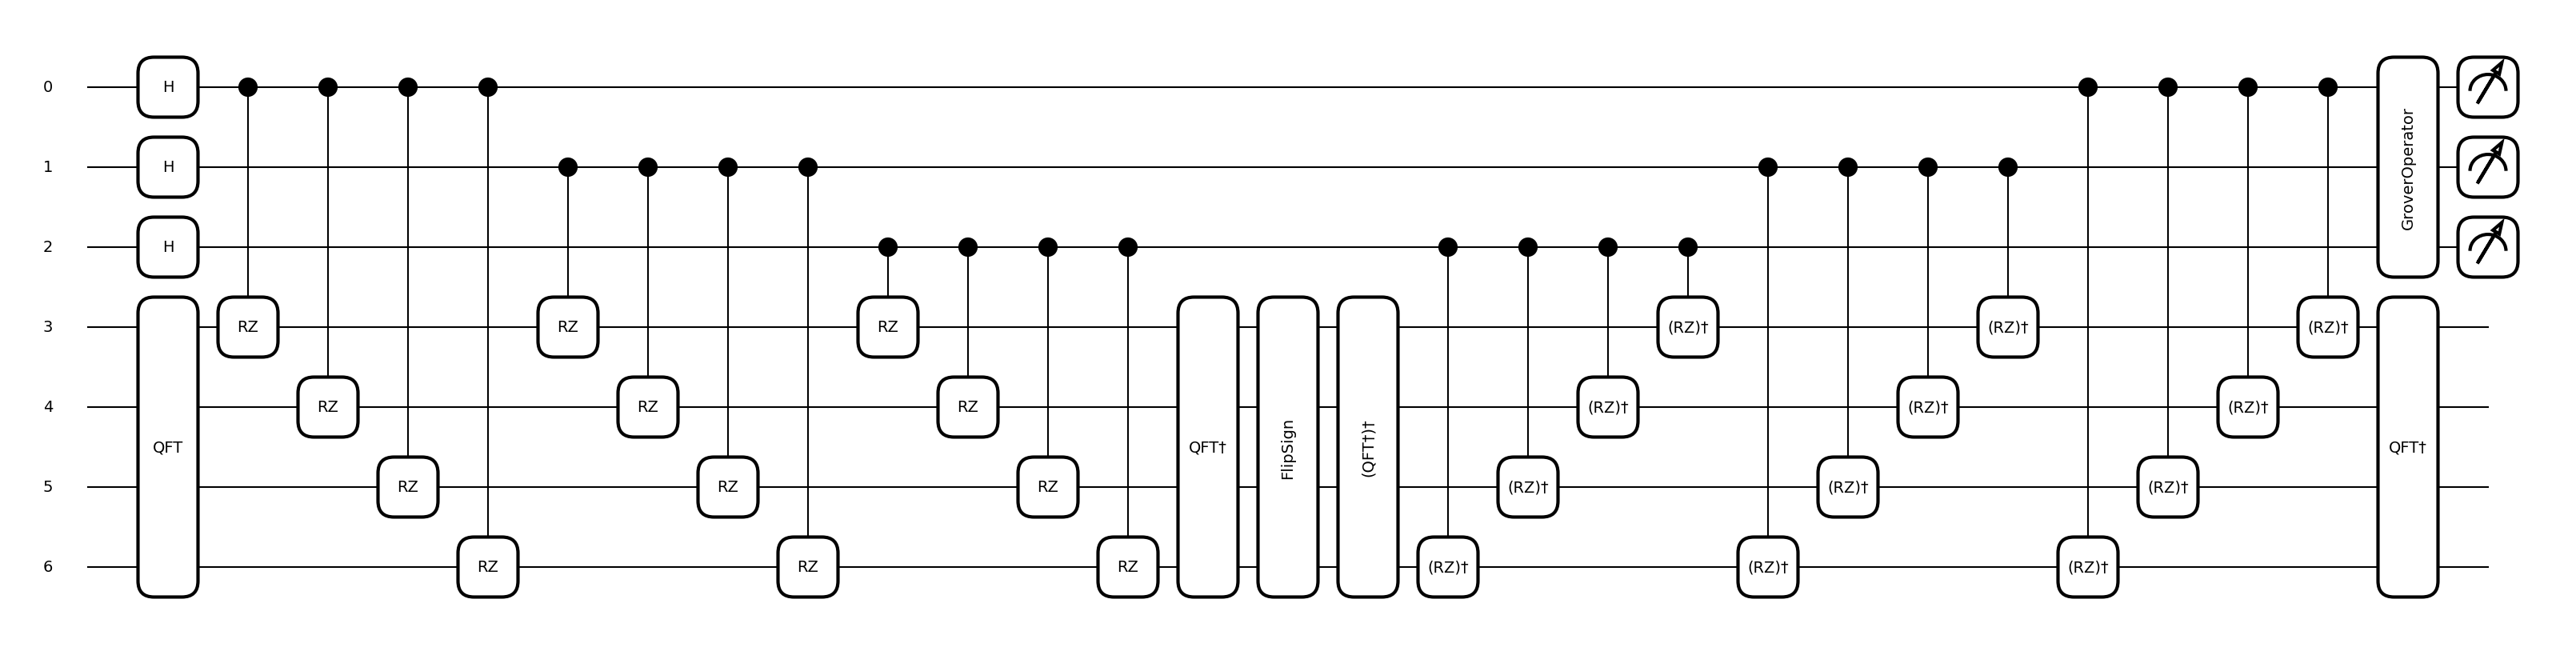

In [8]:
qml.draw_mpl(find_the_primes_numbers, show_all_wires=True)(num, prime_list, variables_wires, aux_oracle_wires)
plt.show()

# 2. Test 

To test the previous code, I have summarize the code in two functions `probs` and `measure`. The first function outputs the probability of all the possible states. The second function, performs a measurement of the previous circuit. 

**Warning:** Although the quantum circuit will guarantee that the right solution will be the one with higher probability, the function `measure` can yield the wrong solution. It is a good practice to always double check if the output of `measure` is the state with the highest probability.

In [9]:
def probs(num, prime_list, variables_wires, aux_oracle_wires, iterations):
    dev = qml.device("default.qubit", wires = variables_wires + aux_oracle_wires)

    @qml.qnode(dev)
    def find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations):

        for wire in variables_wires:
            qml.Hadamard(wires=wire)
        for _ in range(iterations):
            oracle_primes(num, prime_list, variables_wires, aux_oracle_wires)
            qml.GroverOperator(wires = variables_wires)
        return qml.probs(wires=variables_wires)
    
    return find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations)


def measure(num, prime_list, variables_wires, aux_oracle_wires, iterations):
    dev = qml.device("default.qubit", wires = variables_wires + aux_oracle_wires, shots=1)

    @qml.qnode(dev)
    def find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations):

        for wire in variables_wires:
            qml.Hadamard(wires=wire)
        for _ in range(iterations):
            oracle_primes(num, prime_list, variables_wires, aux_oracle_wires)
            qml.GroverOperator(wires = variables_wires)
        return qml.sample(wires=variables_wires)
    
    return find_the_primes_numbers(num, prime_list, variables_wires, aux_oracle_wires, iterations)

result in binary = [1 0 1 1]
result in interger = 9
Is the result correct? True


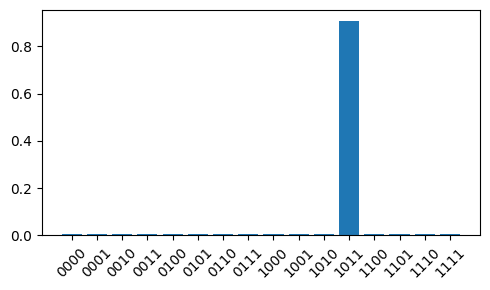

In [10]:
num = 9 # try any number from 1 to 11 

prime_list = [1, 2, 3, 5] # 1 is not a prime number, but it allows us to check all number from 1 to 11
primes = np.array(prime_list)
variables_wires = [0, 1, 2, 3]
aux_oracle_wires = [4, 5, 6, 7]

probabilities = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)
result = measure(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)
print(f"result in binary = {result}")
print(f"result in interger = {np.sum(primes[np.where(result == 1)])}")
print("Is the result correct?", np.sum(primes[np.where(result == 1)]) == num)

plt.figure(figsize=(5, 3))
plt.bar(integers_to_binary(range(len(probabilities)), 4), probabilities)
plt.xticks(rotation=45)
plt.tight_layout()

It is interesting to notice that certain numbers can have multiple correct solutions. To be rigorous with the initial statement of the task I should add a filter that only allows solution with that involve two numbers or remove the number 1 from `prime_list`.

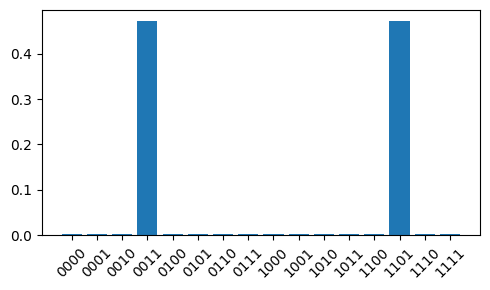

In [11]:
num = 8 

prime_list = [1, 2, 3, 5]
variables_wires = [0, 1, 2, 3]
aux_oracle_wires = [4, 5, 6, 7]

probabilities = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)

plt.figure(figsize=(5, 3))
plt.bar(integers_to_binary(range(len(probabilities)), 4), probabilities)
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Extra

# 3.1 What is the ideal number of iterations?

It is already known that applying the oracle & grover operator a total number of $\lfloor \frac{\pi}{4}\sqrt{N} \rfloor$ times maximize the success probability of the Grover's algorithm, as detailed in this [book](https:/www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview).

A generalization of this problem is when the database has N elements but there are M possible solutions. In this case, the ideal number of iterations is $\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \rfloor$.

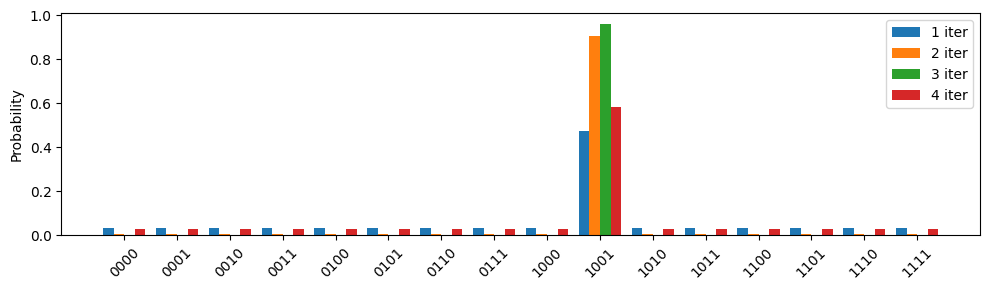

In [40]:
# Checking the ideal number of iterations for M=1
num = 9

prime_list = [2, 3, 5, 7]
variables_wires = [0, 1, 2, 3]
aux_oracle_wires = [4, 5, 6, 7]

# Compute probability for different number of iterations
p1 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=1)
p2 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)
p3 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=3)
p4 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=4)

bar_width = 0.2
x = np.arange(len(p1))
bar1_pos = x - 1.5 * bar_width
bar2_pos = x - 0.5 * bar_width
bar3_pos = x + 0.5 * bar_width
bar4_pos = x + 1.5 * bar_width

plt.figure(figsize=(10, 3))
plt.bar(bar1_pos, p1, width=bar_width, label="1 iter")
plt.bar(bar2_pos, p2, width=bar_width, label="2 iter")
plt.bar(bar3_pos, p3, width=bar_width, label="3 iter")
plt.bar(bar4_pos, p4, width=bar_width, label="4 iter")
plt.ylabel("Probability")
plt.xticks(x, np.array(integers_to_binary(range(len(p1)), 4)), rotation=45)
plt.legend()
plt.tight_layout()

In this case, the optimal number of iterations is 3. This is in agreement with the previous formula, since the number of elements (or possible solution) in the database is $N=2^4=16$. Applying the previous formula 
$$\lfloor \frac{\pi}{4}\sqrt{16} \rfloor = 3$$

In the 4th iteration the probability decrease because the amplitude coefficients interfere with each other (see [link](https://pennylane.ai/qml/demos/tutorial_grovers_algorithm) for a geometrical explanation).

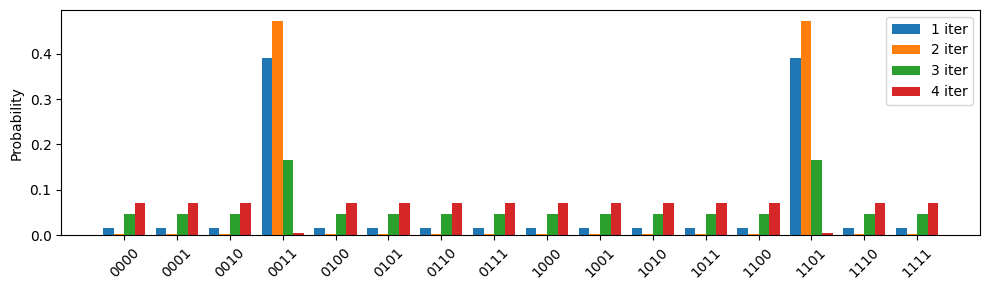

In [44]:
# Checking the ideal number of iterations for M=2
num = 8

prime_list = [1, 2, 3, 5]
variables_wires = [0, 1, 2, 3]
aux_oracle_wires = [4, 5, 6, 7]

# Compute probability for different number of iterations
p1 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=1)
p2 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=2)
p3 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=3)
p4 = probs(num, prime_list, variables_wires, aux_oracle_wires, iterations=4)

bar_width = 0.2
x = np.arange(len(p1))
bar1_pos = x - 1.5 * bar_width
bar2_pos = x - 0.5 * bar_width
bar3_pos = x + 0.5 * bar_width
bar4_pos = x + 1.5 * bar_width

plt.figure(figsize=(10, 3))
plt.bar(bar1_pos, p1, width=bar_width, label="1 iter")
plt.bar(bar2_pos, p2, width=bar_width, label="2 iter")
plt.bar(bar3_pos, p3, width=bar_width, label="3 iter")
plt.bar(bar4_pos, p4, width=bar_width, label="4 iter")
plt.ylabel("Probability")
plt.xticks(x, np.array(integers_to_binary(range(len(p1)), len(aux_oracle_wires))), rotation=45)
plt.legend()
plt.tight_layout()

In this case, the optimal number of iterations is 2, Now, the number of iterations is reduced because there are two possible solutions ($M=2$). This is also in agreement with the previous formula. 
$$\lfloor \frac{\pi}{4}\sqrt{\frac{16}{2}} \rfloor = 2$$



# 3.2 Task 2

Given a list of integer numbers, look for a negative number in the list. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case.

```python
def find_negative_numbers(list[int]:list_number):
    """
    list_number : integer list!.
    return the True or False depends of the input
    """
```

Examples: 

```python
A = find_negative_numbers([1,-3,2,15])
print(A)
True

B = find_negative_numbers([1,4,8,11])
print(B)
False

C = find_negative_numbers([-15,-14,2,-1])
print(C)
True
```

This section is unfinished. The following code is able to find if there is one negative number. 

To finish the task I could either preprocess the list of numbers or implement another circuit to detect all negative numbers in the list. The first idea is straight forward, the second idea is a bit more challenging and I think I will need more qubits to solve it.

[4.93038066e-32 1.00000000e+00 4.93038066e-32 4.93038066e-32]


<BarContainer object of 4 artists>

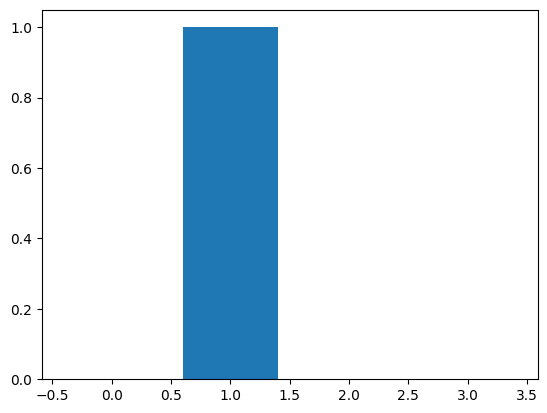

In [99]:
numbers = [1, -3, 2, 15]
num_qubits = int(np.ceil(np.log2(len(numbers))))
iterations = 1

# Auxiliar function
def generate_binary_sequences(length):
    """ Return a binary sequence.
    
    Example: if length = 2
        return [[0,0],[0,1],[1,0],[1,1]]
    """
    if length <= 0:
        return [[]]
    else:
        return [[i] + rest for i in range(2) for rest in generate_binary_sequences(length - 1)]

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit():
    # Apply Hadamard gates to create superposition of all possible states
    for qubit in range(num_qubits):
        qml.Hadamard(wires=qubit)

    # Define the oracle to mark the negative integer
    for _ in range(iterations):
        bin_seq = generate_binary_sequences(length=num_qubits)
        for index, num in enumerate(numbers):
            if num < 0:
                qml.FlipSign(bin_seq[index], wires=range(num_qubits))

        qml.GroverOperator(wires = range(num_qubits))

    # Measure the qubits
    return qml.probs(wires=range(num_qubits))

# Run the circuit
result = circuit()
print(result)
plt.bar(list(range(2**num_qubits)), result)


# 3.3 Disadvantatges of this method

1. As the number of elements increase the superposition state is harder to implement in a real quantum device.
2. Larger numbers require a greater number of qubits compared to smaller numbers.